# Task_Classifier

In [19]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt

In [20]:
# CSV 파일 경로와 이미지 경로
csv_file = "C:/Users/USER/yolov8/custom_datasets/image_dataset.csv"
data = pd.read_csv(csv_file)

In [21]:
# hurdles = 0, poles = 1, ramps = 2, stairs = 3
# 각 클래스별로 데이터 분리
classes = data['label'].unique()
class_data = {}

for cls in classes:
    class_data[cls] = data[data['label'] == cls].reset_index(drop=True)
    print(len(class_data[cls]))


607
1457
700


### 이미지 증강을 위한 변환기
hurdles, poles, ramps, stairs 이미지들의 개수가 각각 다르고 min: 115개 max: 1809개 이기때문에 한쪽은 증강을 시키고 한쪽은 랜덤으로 사용하기

In [22]:
target_num = 1500
# 이미지 증강을 위한 변환기 (train 데이터용)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 통일
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

# 검증 및 테스트용 변환기 (이미지 증강 없이 크기만 조정)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 커스텀 데이터셋 정의
class CustomImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list  # data_list를 초기화
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        label = item['label']
        
        if 'image' in item:
            # 증강된 이미지 (이미 텐서 형태)
            image = item['image']
        else:
            # 파일에서 이미지 로드
            img_path = item['file_path']
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        
        return image, int(label)

In [23]:
from tqdm import tqdm

balanced_data = []

for cls in classes:
    cls_images = class_data[cls]['file_path'].tolist()
    cls_labels = class_data[cls]['label'].tolist()
    current_num = len(cls_images)
    
    print(f"Class '{cls}' has {current_num} images.")
    
    # 기존 이미지를 우선 추가
    for img_path, label in zip(cls_images, cls_labels):
        balanced_data.append({'file_path': img_path, 'label': label})
    
    # 필요한 증강 이미지 수 계산
    augment_num = target_num - current_num
    
    if augment_num > 0:
        print(f"Augmenting {augment_num} images for class '{cls}'.")
        for i in tqdm(range(augment_num)):
            # 원본 이미지 중 하나를 랜덤 선택
            img_path = random.choice(cls_images)
            img = Image.open(img_path)
            
            # 증강 변환 적용
            augmented_img = train_transform(img)
            
            # 증강 이미지를 메모리에 저장 (파일로 저장하지 않고 메모리에서 처리)
            balanced_data.append({'image': augmented_img, 'label': cls})
    else:
        print(f"No augmentation needed for class '{cls}'.")

Class '0' has 607 images.
Augmenting 893 images for class '0'.


100%|██████████| 893/893 [00:07<00:00, 118.97it/s]


Class '1' has 1457 images.
Augmenting 43 images for class '1'.


100%|██████████| 43/43 [00:00<00:00, 74.83it/s]


Class '2' has 700 images.
Augmenting 800 images for class '2'.


100%|██████████| 800/800 [00:07<00:00, 110.02it/s]


In [27]:
# 6. 데이터셋 분할
train_list = []
valid_list = []
test_list = []

for cls in classes:
    cls_data = [item for item in balanced_data if item['label'] == cls]
    random.shuffle(cls_data)
    
    n_total = len(cls_data)
    n_train = int(n_total * 0.7)
    n_valid = int(n_total * 0.2)
    
    train_list.extend(cls_data[:n_train])
    valid_list.extend(cls_data[n_train:n_train + n_valid])
    test_list.extend(cls_data[n_train + n_valid:])

In [28]:
# 7. 데이터로더 생성
train_dataset = CustomImageDataset(train_list, transform=train_transform)
valid_dataset = CustomImageDataset(valid_list, transform=test_transform)
test_dataset = CustomImageDataset(test_list, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data preparation is complete.")

Data preparation is complete.


In [31]:
import pandas as pd

def save_dataset_to_csv(data_list, file_path):
    """
    data_list: [(image_path, label), ...] 형태의 리스트
    file_path: 저장할 CSV 파일 경로
    """
    df = pd.DataFrame(data_list, columns=["image_path", "label"])
    df.to_csv(file_path, index=False)
    
# 예시: train_list, valid_list, test_list를 각각 CSV로 저장
save_dataset_to_csv(train_list, 'train_data.csv')
save_dataset_to_csv(valid_list, 'valid_data.csv')
save_dataset_to_csv(test_list, 'test_data.csv')


In [32]:
# DataLoader로부터 데이터 불러오기
data_iter = iter(train_loader)
images, labels = next(data_iter)  # 수정된 부분

print(images.shape)  # [batch_size, channels, height, width]
print(images)
print(labels.shape)  # [batch_size]


torch.Size([32, 3, 224, 224])
tensor([[[[0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333]],

         [[0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333]],

         [[0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0.1333, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
          [0

## 모델 구현

In [50]:
# 1. ResNet50 모델 불러오기 및 커스터마이징
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4개의 클래스 (허들, 폴대, 램프, 계단)

# 2. GPU 사용 여부 확인 및 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # GPU 사용 여부 출력
model = model.to(device)

# 3. 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 기록을 위한 리스트 초기화
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

num_epochs = 25
best_accuracy = 0.0

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu


In [36]:
for epoch in range(num_epochs):
    # 훈련 모드 설정
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # tqdm으로 train_loader 감싸기 (배치 진행 상황 표시)
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 배치 진행 상황에 따라 업데이트
        train_loader_tqdm.set_postfix(loss=loss.item(), accuracy=correct / total * 100)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 모드 설정
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    valid_loader_tqdm = tqdm(valid_loader, desc="Validating", unit="batch")  # tqdm으로 valid_loader 감싸기

    with torch.no_grad():
        for images, labels in valid_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    valid_accuracy = correct / total * 100
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # 체크포인트 저장 (최고 검증 정확도를 기록한 모델)
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'accuracy': best_accuracy,
        }, f"checkpoint_epoch_{epoch+1}.pth.tar")

    # 에폭 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%")

Validating: 100%|██████████| 29/29 [01:38<00:00,  3.39s/batch]


Epoch 1/15, Train Loss: 0.2196, Train Acc: 93.14%, Valid Loss: 0.2187, Valid Acc: 93.33%


Validating: 100%|██████████| 29/29 [01:18<00:00,  2.71s/batch]


Epoch 2/15, Train Loss: 0.1723, Train Acc: 94.48%, Valid Loss: 0.2182, Valid Acc: 93.00%


Validating: 100%|██████████| 29/29 [01:17<00:00,  2.69s/batch]


Epoch 3/15, Train Loss: 0.1379, Train Acc: 95.87%, Valid Loss: 0.4532, Valid Acc: 85.78%


Validating: 100%|██████████| 29/29 [00:41<00:00,  1.44s/batch]


Epoch 4/15, Train Loss: 0.1410, Train Acc: 95.87%, Valid Loss: 0.1113, Valid Acc: 97.00%


Validating: 100%|██████████| 29/29 [01:31<00:00,  3.15s/batch]


Epoch 5/15, Train Loss: 0.1457, Train Acc: 96.57%, Valid Loss: 0.1377, Valid Acc: 95.33%


Validating: 100%|██████████| 29/29 [01:26<00:00,  2.98s/batch]


Epoch 6/15, Train Loss: 0.1582, Train Acc: 95.52%, Valid Loss: 0.1399, Valid Acc: 95.22%


Validating: 100%|██████████| 29/29 [00:21<00:00,  1.34batch/s]


Epoch 7/15, Train Loss: 0.1086, Train Acc: 96.83%, Valid Loss: 0.1062, Valid Acc: 97.11%


Validating: 100%|██████████| 29/29 [01:07<00:00,  2.34s/batch]


Epoch 8/15, Train Loss: 0.1127, Train Acc: 96.51%, Valid Loss: 0.1001, Valid Acc: 97.11%


Validating: 100%|██████████| 29/29 [01:17<00:00,  2.66s/batch]


Epoch 9/15, Train Loss: 0.1105, Train Acc: 96.60%, Valid Loss: 0.2694, Valid Acc: 91.11%


Validating: 100%|██████████| 29/29 [01:16<00:00,  2.63s/batch]


Epoch 10/15, Train Loss: 0.1141, Train Acc: 96.76%, Valid Loss: 0.1165, Valid Acc: 97.22%


Validating: 100%|██████████| 29/29 [00:31<00:00,  1.09s/batch]


Epoch 11/15, Train Loss: 0.1077, Train Acc: 96.76%, Valid Loss: 0.1146, Valid Acc: 96.56%


Validating: 100%|██████████| 29/29 [01:48<00:00,  3.73s/batch]


Epoch 12/15, Train Loss: 0.1067, Train Acc: 96.92%, Valid Loss: 0.1004, Valid Acc: 97.11%


Validating: 100%|██████████| 29/29 [00:56<00:00,  1.95s/batch]


Epoch 13/15, Train Loss: 0.0951, Train Acc: 97.08%, Valid Loss: 0.1070, Valid Acc: 97.33%


Validating: 100%|██████████| 29/29 [00:55<00:00,  1.90s/batch]


Epoch 14/15, Train Loss: 0.1038, Train Acc: 96.83%, Valid Loss: 0.0889, Valid Acc: 97.11%


Validating: 100%|██████████| 29/29 [00:55<00:00,  1.90s/batch]

Epoch 15/15, Train Loss: 0.1136, Train Acc: 96.76%, Valid Loss: 0.1621, Valid Acc: 95.78%


In [51]:
# 25
for epoch in range(num_epochs):
    # 훈련 모드 설정
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # tqdm으로 train_loader 감싸기 (배치 진행 상황 표시)
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for images, labels in train_loader_tqdm:
        # 데이터를 GPU로 이동
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 배치 진행 상황에 따라 업데이트
        train_loader_tqdm.set_postfix(loss=loss.item(), accuracy=correct / total * 100)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 모드 설정
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    valid_loader_tqdm = tqdm(valid_loader, desc="Validating", unit="batch")  # tqdm으로 valid_loader 감싸기

    with torch.no_grad():
        for images, labels in valid_loader_tqdm:
            # 검증 시 데이터도 GPU로 이동
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    valid_accuracy = correct / total * 100
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # 체크포인트 저장 (최고 검증 정확도를 기록한 모델)
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'accuracy': best_accuracy,
        }, f"checkpoint_epoch_{epoch+1}.pth.tar")

    # 에폭 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%")


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.78s/batch]


Epoch 1/25, Train Loss: 0.2377, Train Acc: 92.41%, Valid Loss: 0.2747, Valid Acc: 91.78%


Validating: 100%|██████████| 29/29 [00:54<00:00,  1.89s/batch]


Epoch 2/25, Train Loss: 0.1607, Train Acc: 95.33%, Valid Loss: 1.0479, Valid Acc: 66.89%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.77s/batch]


Epoch 3/25, Train Loss: 0.1889, Train Acc: 94.16%, Valid Loss: 0.1382, Valid Acc: 95.89%


Validating: 100%|██████████| 29/29 [00:56<00:00,  1.96s/batch]


Epoch 4/25, Train Loss: 0.1285, Train Acc: 96.10%, Valid Loss: 0.0897, Valid Acc: 97.44%


Validating: 100%|██████████| 29/29 [00:58<00:00,  2.02s/batch]


Epoch 5/25, Train Loss: 0.1317, Train Acc: 95.87%, Valid Loss: 0.0981, Valid Acc: 97.22%


Validating: 100%|██████████| 29/29 [00:55<00:00,  1.93s/batch]


Epoch 6/25, Train Loss: 0.1369, Train Acc: 95.87%, Valid Loss: 0.1043, Valid Acc: 97.22%


Validating: 100%|██████████| 29/29 [00:50<00:00,  1.76s/batch]


Epoch 7/25, Train Loss: 0.1135, Train Acc: 96.76%, Valid Loss: 0.1087, Valid Acc: 96.89%


Validating: 100%|██████████| 29/29 [00:55<00:00,  1.90s/batch]


Epoch 8/25, Train Loss: 0.1155, Train Acc: 96.35%, Valid Loss: 0.3497, Valid Acc: 85.22%


Validating: 100%|██████████| 29/29 [00:50<00:00,  1.75s/batch]


Epoch 9/25, Train Loss: 0.1089, Train Acc: 96.79%, Valid Loss: 0.1052, Valid Acc: 96.67%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.76s/batch]


Epoch 10/25, Train Loss: 0.1065, Train Acc: 96.95%, Valid Loss: 0.0996, Valid Acc: 96.78%


Validating: 100%|██████████| 29/29 [00:50<00:00,  1.75s/batch]


Epoch 11/25, Train Loss: 0.1048, Train Acc: 96.83%, Valid Loss: 0.0907, Valid Acc: 97.22%


Validating: 100%|██████████| 29/29 [00:50<00:00,  1.75s/batch]


Epoch 12/25, Train Loss: 0.1024, Train Acc: 96.86%, Valid Loss: 0.1176, Valid Acc: 95.44%


Validating: 100%|██████████| 29/29 [00:50<00:00,  1.74s/batch]


Epoch 13/25, Train Loss: 0.1355, Train Acc: 95.97%, Valid Loss: 3.4227, Valid Acc: 64.56%


Validating: 100%|██████████| 29/29 [00:50<00:00,  1.75s/batch]


Epoch 14/25, Train Loss: 0.1200, Train Acc: 96.63%, Valid Loss: 0.0962, Valid Acc: 97.11%


Validating: 100%|██████████| 29/29 [00:53<00:00,  1.84s/batch]


Epoch 15/25, Train Loss: 0.1076, Train Acc: 96.60%, Valid Loss: 0.1498, Valid Acc: 95.67%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.79s/batch]


Epoch 16/25, Train Loss: 0.0986, Train Acc: 97.05%, Valid Loss: 0.1110, Valid Acc: 96.22%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.78s/batch]


Epoch 17/25, Train Loss: 0.1130, Train Acc: 96.92%, Valid Loss: 0.1358, Valid Acc: 95.44%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.79s/batch]


Epoch 18/25, Train Loss: 0.1018, Train Acc: 96.98%, Valid Loss: 0.0945, Valid Acc: 97.33%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.78s/batch]


Epoch 19/25, Train Loss: 0.1043, Train Acc: 96.89%, Valid Loss: 0.1166, Valid Acc: 96.22%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.78s/batch]


Epoch 20/25, Train Loss: 0.1041, Train Acc: 97.11%, Valid Loss: 0.0933, Valid Acc: 97.22%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.78s/batch]


Epoch 21/25, Train Loss: 0.0975, Train Acc: 97.14%, Valid Loss: 0.1183, Valid Acc: 96.00%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.79s/batch]


Epoch 22/25, Train Loss: 0.0924, Train Acc: 97.40%, Valid Loss: 0.1198, Valid Acc: 96.67%


Validating: 100%|██████████| 29/29 [00:51<00:00,  1.79s/batch]


Epoch 23/25, Train Loss: 0.0937, Train Acc: 97.46%, Valid Loss: 0.0869, Valid Acc: 97.33%


Validating: 100%|██████████| 29/29 [00:52<00:00,  1.80s/batch]


Epoch 24/25, Train Loss: 0.1160, Train Acc: 97.14%, Valid Loss: 0.1014, Valid Acc: 96.67%


Validating: 100%|██████████| 29/29 [00:52<00:00,  1.80s/batch]

Epoch 25/25, Train Loss: 0.1857, Train Acc: 94.00%, Valid Loss: 0.1076, Valid Acc: 96.56%


In [59]:
import torch
import heapq

# 14 epoch 이후의 검증 정확도와 에폭 번호를 추출
valid_accuracies_after_14 = valid_accuracies[14:]
epochs_after_14 = list(range(14, len(valid_accuracies)))

# 상위 6개의 정확도와 해당 에폭 번호 추출
top_6 = heapq.nlargest(6, zip(valid_accuracies_after_14, epochs_after_14))

# 상위 6개의 모델 저장
for i, (accuracy, epoch) in enumerate(top_6, 1):
    torch.save({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'accuracy': accuracy,
        'loss': valid_losses[epoch]
    }, f"top_{i}_model_epoch_{epoch+1}.pth.tar")

    print(f"Model {i} from epoch {epoch+1} saved with accuracy: {accuracy:.2f}% and loss: {valid_losses[epoch]:.4f}")




Model 1 from epoch 23 saved with accuracy: 97.33% and loss: 0.0869
Model 2 from epoch 18 saved with accuracy: 97.33% and loss: 0.0945
Model 3 from epoch 20 saved with accuracy: 97.22% and loss: 0.0933
Model 4 from epoch 24 saved with accuracy: 96.67% and loss: 0.1014
Model 5 from epoch 22 saved with accuracy: 96.67% and loss: 0.1198
Model 6 from epoch 25 saved with accuracy: 96.56% and loss: 0.1076


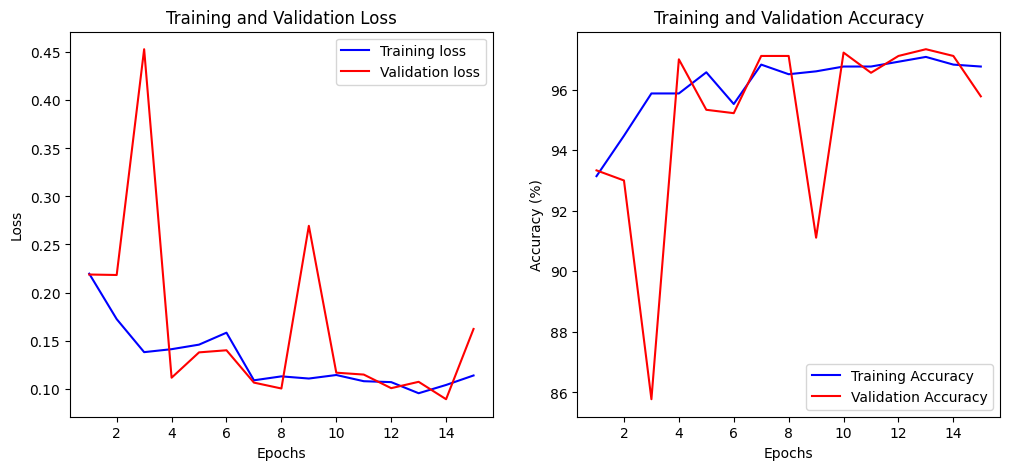

In [37]:
 # 6. 학습 결과 그래프 그리기
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# 학습 및 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 학습 및 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, valid_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# 그래프 출력
plt.show()

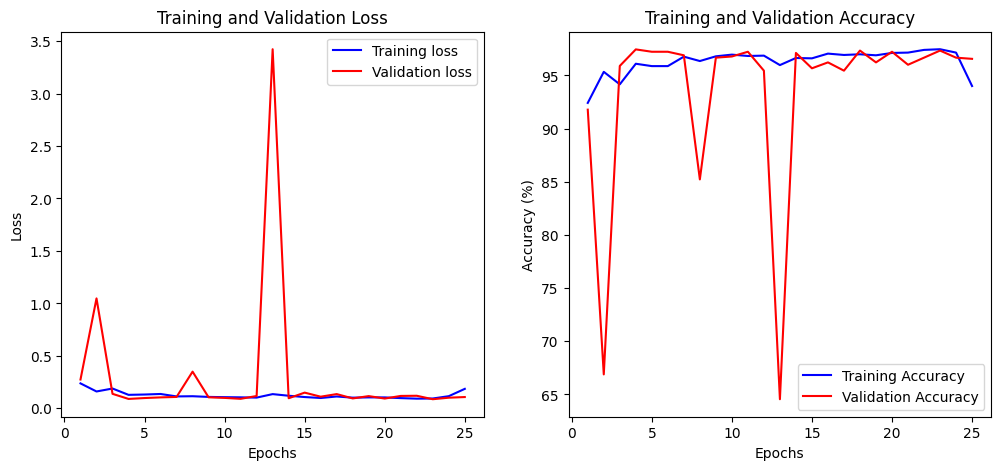

In [52]:
 # 6. 학습 결과 그래프 그리기
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# 학습 및 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 학습 및 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, valid_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# 그래프 출력
plt.show()

In [42]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 1. 이미지 불러오기 및 변환
def load_and_preprocess_image(image_path):
    # 모델에서 사용된 변환과 동일한 변환 적용
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet의 평균과 표준편차
    ])
    
    image = Image.open(image_path).convert('RGB')  # 이미지 열기 및 RGB로 변환
    image = transform(image).unsqueeze(0)  # 배치 차원 추가 (모델은 배치 단위로 입력받기 때문)
    
    return image

# 2. 훈련된 모델 불러오기
def load_trained_model(checkpoint_path):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)  # 4개의 클래스 (허들, 폴대, 램프, 계단)
    
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))  # CPU로 로드
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()  # 모델을 평가 모드로 설정
    
    return model

# 3. 예측 함수
def predict_image(model, image_tensor):
    with torch.no_grad():  # 그래디언트 계산 비활성화 (추론 단계에서만 사용)
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # 가장 높은 값을 가진 클래스로 예측
        return predicted.item()

# 4. 테스트 함수
def test_single_image(image_path, checkpoint_path, class_names):
    # 이미지 불러오기 및 전처리
    image_tensor = load_and_preprocess_image(image_path)
    
    # 모델 불러오기
    model = load_trained_model(checkpoint_path)
    
    # 예측 수행
    predicted_class_idx = predict_image(model, image_tensor)
    
    # 결과 출력
    print(f"Predicted class: {class_names[predicted_class_idx]}")
    
    # 이미지 시각화
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted_class_idx]}")
    plt.show()

# 클래스 이름 (레이블 순서에 맞게 설정)
class_names = ['Hurdle', 'Pole', 'Ramp']

C:\Users\USER\AppData\Local\Temp\ipykernel_31712\2868244157.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.

Predicted class: Hurdle


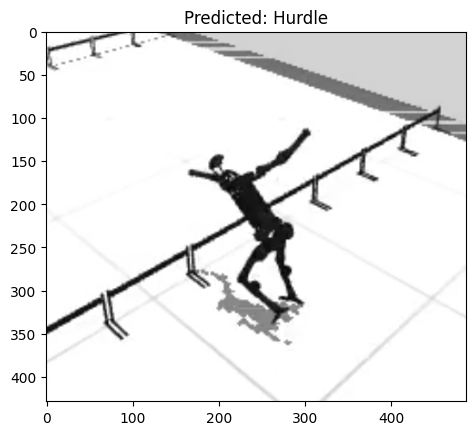

Predicted class: Hurdle


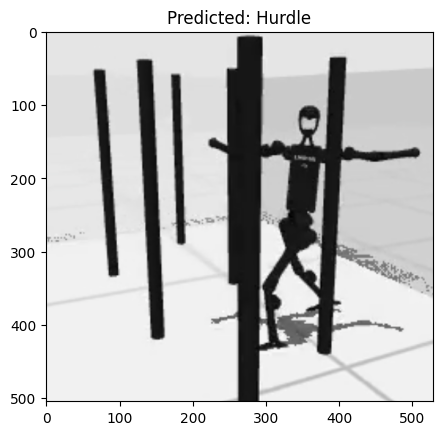

Predicted class: Hurdle


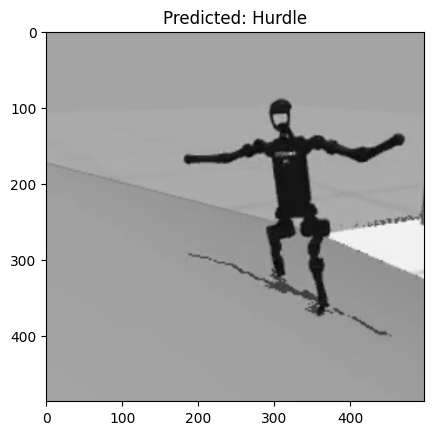

In [48]:
# 테스트할 이미지 경로
hurdle_path = "C:/Users/USER/yolov8/custom_datasets/test/test_hurdle.png"
pole_path = "C:/Users/USER/yolov8/custom_datasets/test/test_pole.png"
ramp_path = "C:/Users/USER/yolov8/custom_datasets/test/test_ramp.png"
checkpoint_path = 'C:/Users/USER/yolov8/checkpoint_epoch_10.pth.tar'  # 체크포인트 파일 경로

# 테스트 수행
test_single_image(hurdle_path, checkpoint_path, class_names)
test_single_image(pole_path, checkpoint_path, class_names)
test_single_image(ramp_path, checkpoint_path, class_names)


C:\Users\USER\AppData\Local\Temp\ipykernel_31712\2868244157.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.

Predicted class: Hurdle


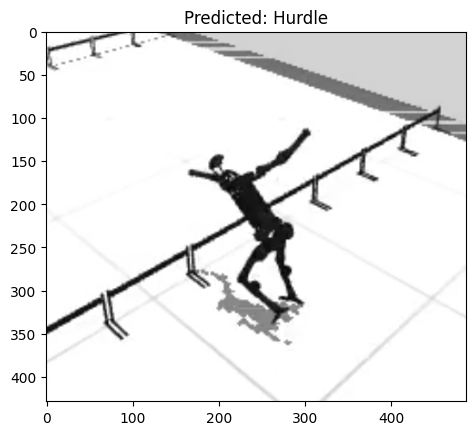

Predicted class: Hurdle


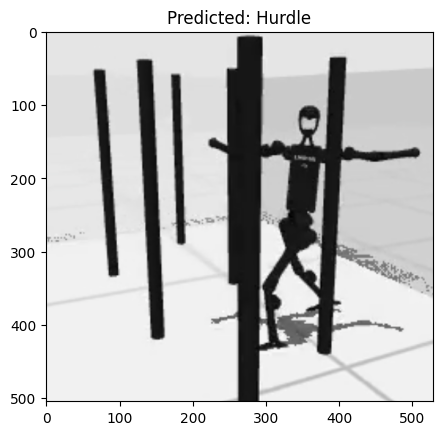

Predicted class: Ramp


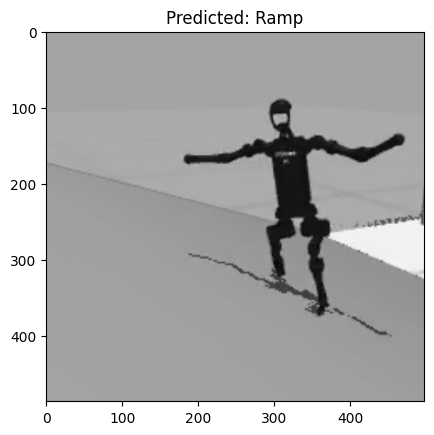

In [49]:
# 테스트할 이미지 경로
checkpoint_path = 'C:/Users/USER/yolov8/checkpoint_epoch_13.pth.tar'  # 체크포인트 파일 경로

# 테스트 수행
test_single_image(hurdle_path, checkpoint_path, class_names)
test_single_image(pole_path, checkpoint_path, class_names)
test_single_image(ramp_path, checkpoint_path, class_names)

top1


C:\Users\USER\AppData\Local\Temp\ipykernel_31712\2868244157.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.

Predicted class: Hurdle


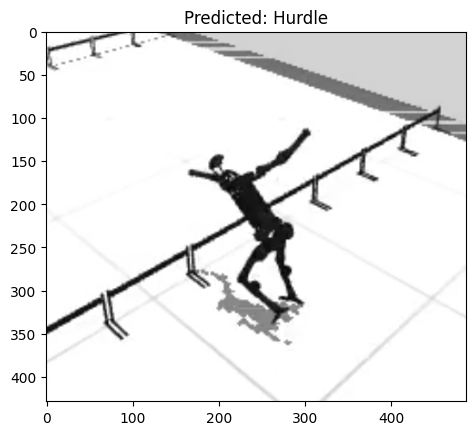

Predicted class: Ramp


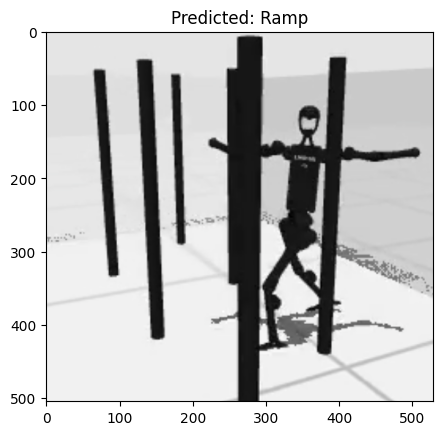

Predicted class: Hurdle


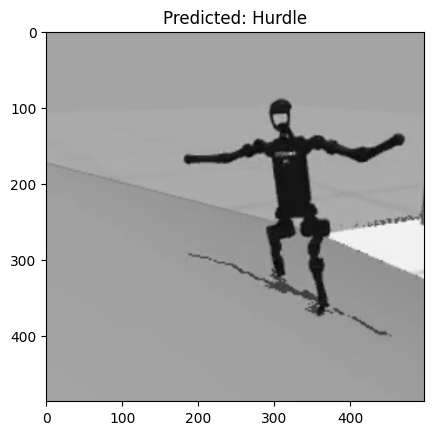

top2
Predicted class: Hurdle


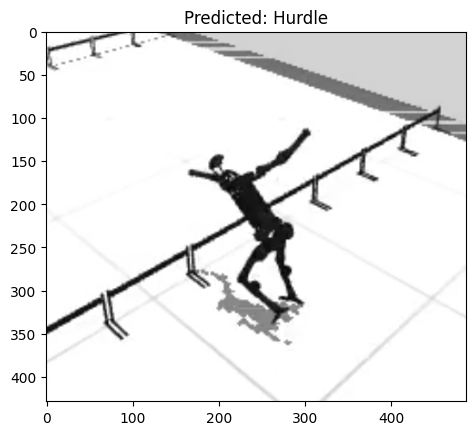

Predicted class: Ramp


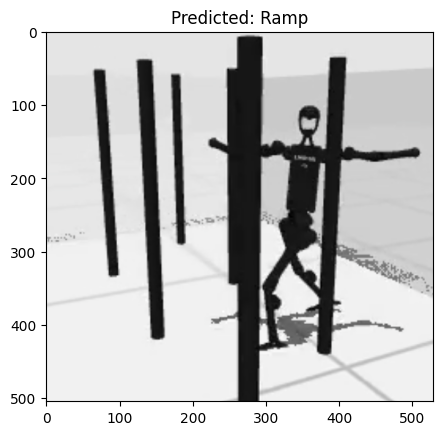

Predicted class: Hurdle


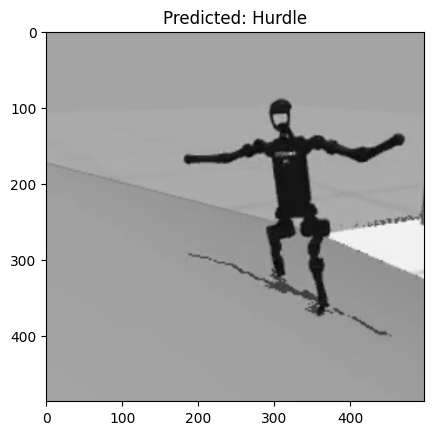

top3
Predicted class: Hurdle


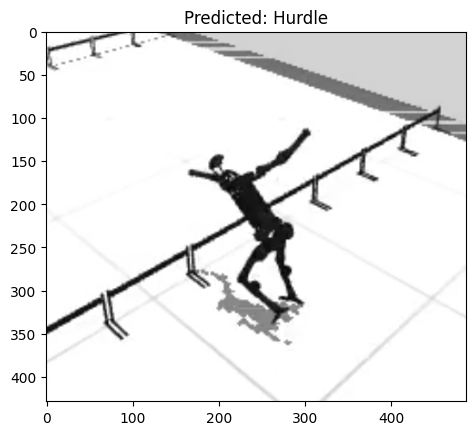

Predicted class: Ramp


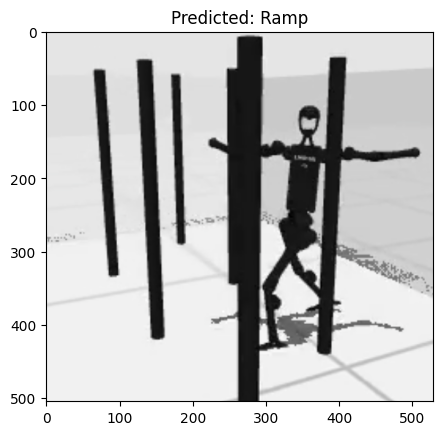

Predicted class: Hurdle


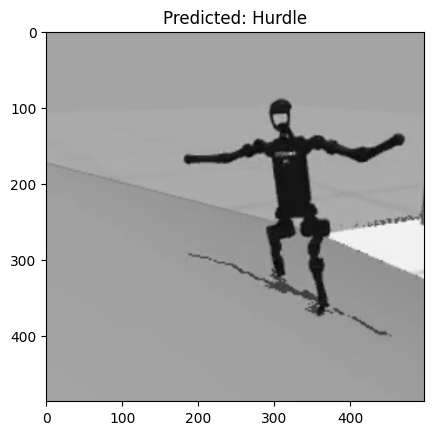

top4
Predicted class: Hurdle


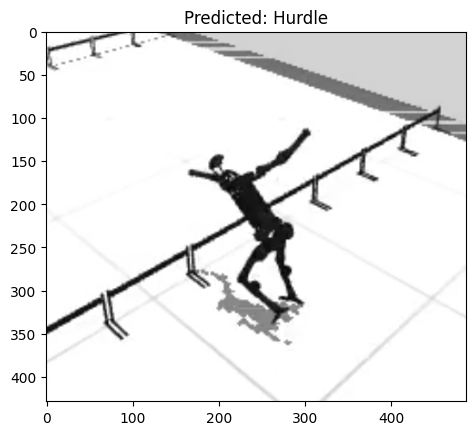

Predicted class: Ramp


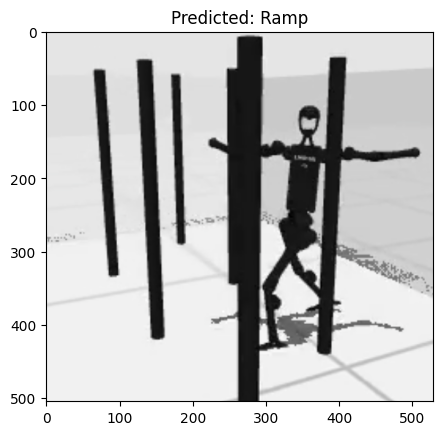

Predicted class: Hurdle


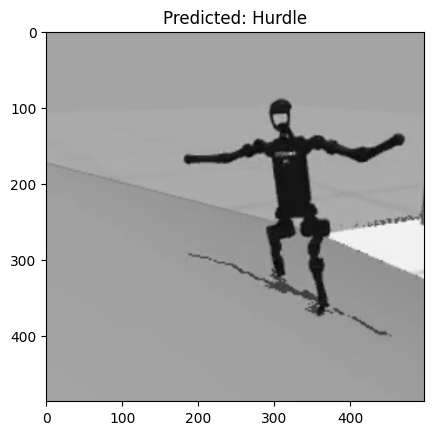

top5
Predicted class: Hurdle


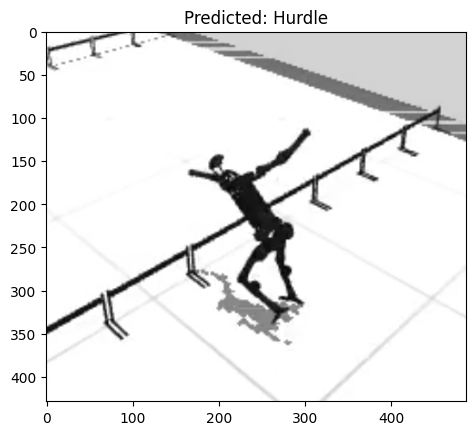

Predicted class: Ramp


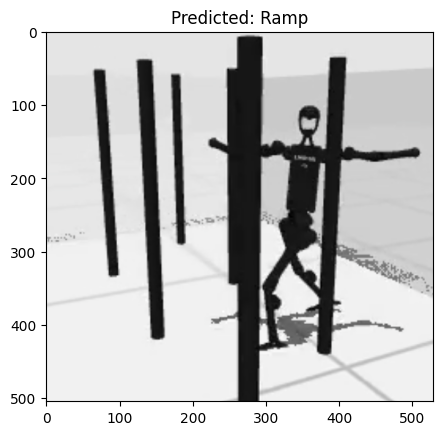

Predicted class: Hurdle


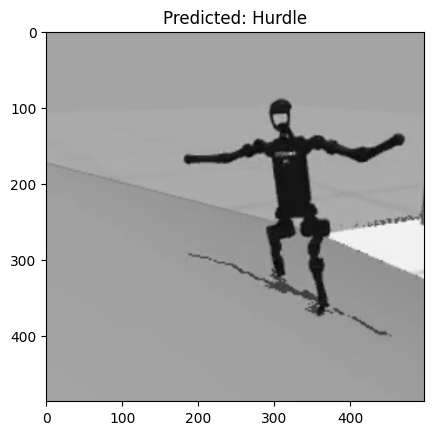

top6
Predicted class: Hurdle


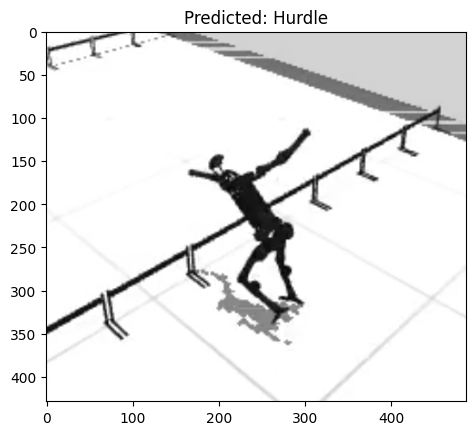

Predicted class: Ramp


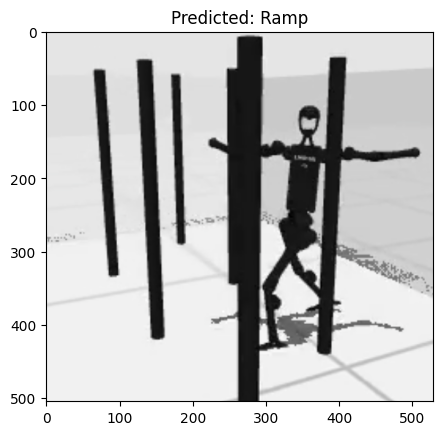

Predicted class: Hurdle


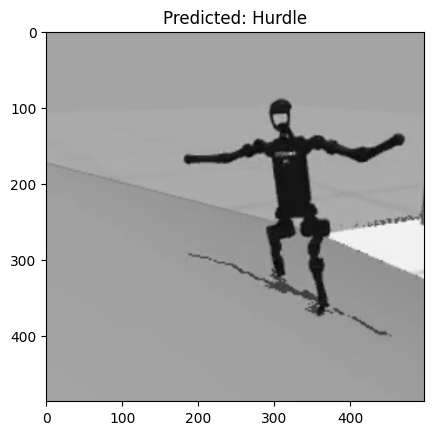

In [62]:
# epcoh 25로 돌렸을때 상위 6 테스트 
# 테스트할 이미지 경로
checkpoint_paths = ["C:/Users/USER/yolov8/top_1_model_epoch_23.pth.tar", "C:/Users/USER/yolov8/top_2_model_epoch_18.pth.tar",
                    "C:/Users/USER/yolov8/top_3_model_epoch_20.pth.tar", "C:/Users/USER/yolov8/top_4_model_epoch_24.pth.tar",
                    "C:/Users/USER/yolov8/top_5_model_epoch_22.pth.tar", "C:/Users/USER/yolov8/top_6_model_epoch_25.pth.tar"]  # 체크포인트 파일 경로

# 테스트 수행
i= 1
for checkpoint_path in checkpoint_paths:
    print(f'top{i}')
    test_single_image(hurdle_path, checkpoint_path, class_names)
    test_single_image(pole_path, checkpoint_path, class_names)
    test_single_image(ramp_path, checkpoint_path, class_names)
    i += 1

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\USER\AppData\Local\Temp\ipykernel_31712\2868244157.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future re

Predicted class: Ramp


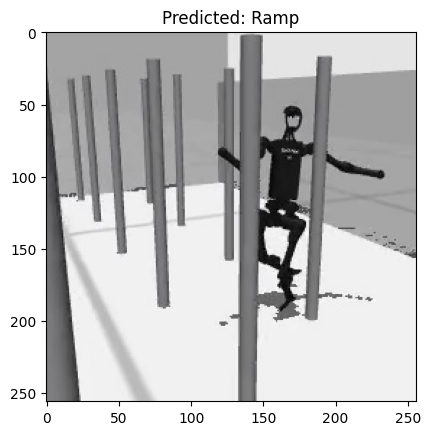

Predicted class: Ramp


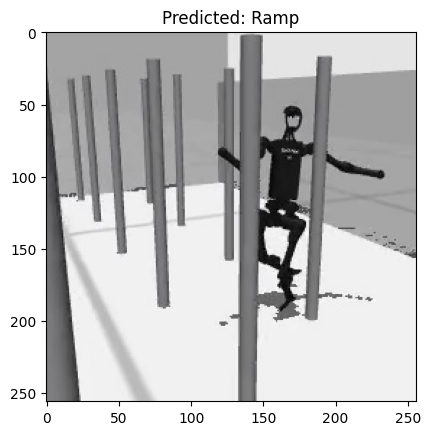

Predicted class: Ramp


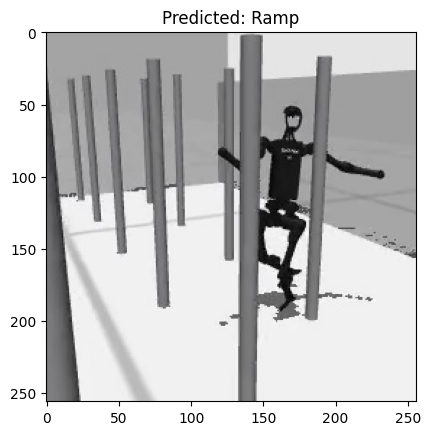

Predicted class: Ramp


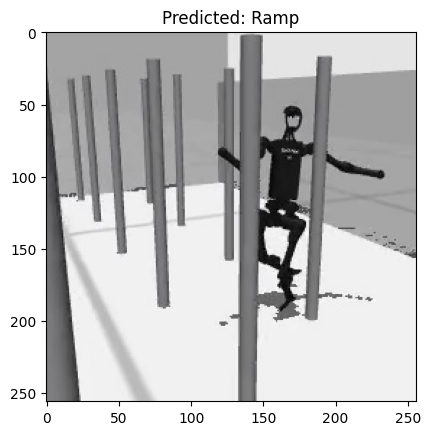

Predicted class: Ramp


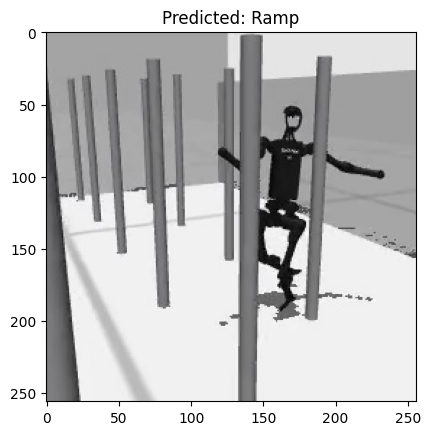

Predicted class: Ramp


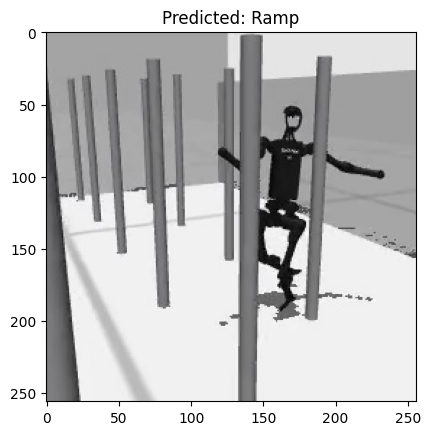

In [63]:
# 테스트할 이미지 경로
image_path = "C:/Users/USER/yolov8/custom_datasets/test/pole.jpg"

# 테스트 수행
for checkpoint_path in checkpoint_paths:
    test_single_image(image_path, checkpoint_path, class_names)


위의 모델은 결과가 좋지 않아 yolo backbone을 사용해봄.
## Yolo backbone을 이용한 classification

1. 데이터 증강 및 데이터셋 분할

In [116]:
import os
import random
from PIL import Image
from torchvision import transforms

# 데이터 증강 설정
augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# 디렉토리 존재 여부 확인 및 생성 함수
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# 증강 및 저장하는 함수
def augment_images(input_dir, output_dir, target_count):
    # 저장할 경로가 없다면 생성
    ensure_dir(output_dir)

    images = os.listdir(input_dir)
    num_existing_images = len(images)
    num_augments_needed = target_count - num_existing_images
    
    # 기존 이미지 복사
    for img in images:
        img_path = os.path.join(input_dir, img)
        img = Image.open(img_path)
        img_name = os.path.basename(img_path)  # 이미지 이름 추출
        img.save(os.path.join(output_dir, img_name))
    
    # 증강된 이미지 생성
    for i in range(num_augments_needed):
        img_path = random.choice(images)
        img = Image.open(os.path.join(input_dir, img_path))
        
        augmented_img = augmentation_transforms(img)
        augmented_img_pil = transforms.ToPILImage()(augmented_img)  # 다시 PIL 이미지로 변환
        
        augmented_img_pil.save(os.path.join(output_dir, f'augmented_{i}.jpg'))

# 각 클래스에 대해 증강 적용
augment_images('custom_datasets/hurdles', 'custom_datasets/augmented_hurdles', 1500)
augment_images('custom_datasets/poles', 'custom_datasets/augmented_poles', 1500)
augment_images('custom_datasets/ramps', 'custom_datasets/augmented_ramps', 1500)



In [117]:
import shutil
from sklearn.model_selection import train_test_split

# 데이터를 train, valid, test로 나누는 함수
def split_data(source_dir, train_dir, valid_dir, test_dir, train_ratio=0.7, valid_ratio=0.2):
    images = os.listdir(source_dir)
    train_images, test_images = train_test_split(images, test_size=(1-train_ratio))
    valid_images, test_images = train_test_split(test_images, test_size=(1-valid_ratio/(1-train_ratio)))

    # 폴더 생성
    for img_set, target_dir in [(train_images, train_dir), (valid_images, valid_dir), (test_images, test_dir)]:
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)
        for img in img_set:
            shutil.copy(os.path.join(source_dir, img), os.path.join(target_dir, img))

# 증강된 데이터를 나누기
split_data('custom_datasets/augmented_hurdles', 'custom_dataset/train/hurdles', 'custom_dataset/valid/hurdles', 'custom_dataset/test/hurdles')
split_data('custom_datasets/augmented_poles', 'custom_dataset/train/poles', 'custom_dataset/valid/poles', 'custom_dataset/test/poles')
split_data('custom_datasets/augmented_ramps', 'custom_dataset/train/ramps', 'custom_dataset/valid/ramps', 'custom_dataset/test/ramps')



In [73]:
from ultralytics import YOLO

# YOLO 모델에서 Backbone을 사용한 Classification
# yolov8n-cls.pt는 YOLOv8 분류 모델의 사전 학습된 가중치입니다
model = YOLO('yolov8n-cls.pt')

# 데이터셋 경로 설정
data = 'custom_dataset/'  # train, valid, test 폴더가 포함된 경로

# 모델 학습
model.train(data=data, epochs=10, imgsz=224, batch=32)


100%|██████████| 5.31M/5.31M [00:01<00:00, 3.38MB/s]


New https://pypi.org/project/ultralytics/8.3.17 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.14  Python-3.12.6 torch-2.4.1+cpu CPU (13th Gen Intel Core(TM) i9-13900H)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=custom_dataset/, epochs=10, time=None, patience=100, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning C:\Users\USER\yolov8\custom_dataset\train... 3147 images, 0 corrupt: 100%|██████████| 3147/3147 [00:05<00:00, 615.77it/s]


train: New cache created: C:\Users\USER\yolov8\custom_dataset\train.cache


val: Scanning C:\Users\USER\yolov8\custom_dataset\test... 453 images, 0 corrupt: 100%|██████████| 453/453 [00:00<00:00, 634.16it/s]

val: New cache created: C:\Users\USER\yolov8\custom_dataset\test.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\classify\train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.57it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10         0G    0.07967         11        224: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]

                   all      0.978          1



10 epochs completed in 0.186 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.0MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.0MB

Validating runs\classify\train\weights\best.pt...
Ultralytics 8.3.14  Python-3.12.6 torch-2.4.1+cpu CPU (13th Gen Intel Core(TM) i9-13900H)
YOLOv8n-cls summary (fused): 73 layers, 1,438,723 parameters, 0 gradients, 3.3 GFLOPs
WARNING  Dataset 'split=val' not found, using 'split=test' instead.
train: C:\Users\USER\yolov8\custom_dataset\train... found 3147 images in 3 classes  
val: None...
test: C:\Users\USER\yolov8\custom_dataset\test... found 453 images in 3 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


                   all      0.982          1
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022B8328D8E0>
curves: []
curves_results: []
fitness: 0.9911699891090393
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9823399782180786, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9911699891090393}
save_dir: WindowsPath('runs/classify/train')
speed: {'preprocess': 0.0, 'inference': 3.525009218430677, 'loss': 0.0, 'postprocess': 0.0}
task: 'classify'
top1: 0.9823399782180786
top5: 1.0

In [81]:
# 훈련된 모델 저장
model.save('best_classification_model.pt')

In [74]:
# 테스트할 이미지의 경로
test_image_path = 'C:/Users/USER/yolov8/custom_dataset/test/hurdles/augmented_20.jpg'

# 이미지 분류 수행
results = model(test_image_path)

# 분류 결과 출력
print(results)


image 1/1 C:\Users\USER\yolov8\custom_dataset\test\hurdles\augmented_20.jpg: 224x224 hurdles 1.00, ramps 0.00, poles 0.00, 0.0ms
Speed: 0.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
[ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'hurdles', 1: 'poles', 2: 'ramps'}
obb: None
orig_img: array([[[ 0,  0,  0],
        [14, 14, 14],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 2,  2,  2],
        [ 4,  4,  4]],

       [[ 0,  0,  0],
        [ 8,  8,  8],
        [ 0,  0,  0],
        ...,
        [10, 10, 10],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 4,  4,  4],
        [ 2,  2,  2],
        ...,
        [ 0,  0,  0],
        [ 4,  4,  4],
        [ 9,  9,  9]],

       ...,

       [[12, 12, 12],
        [ 0,  0,  0],
        [ 3,  3,  3],
        ...,
        [ 8,  8,  8],
        [ 1,  1,  1],
        [ 4,  4,  4]],

      

In [75]:
test_image_path_2 = 'C:/Users/USER/yolov8/custom_dataset/test/poles/pole_699796_3875d3e80a58c441150c_frame_250.jpg'
results2 = model(test_image_path_2)
print(results2)


image 1/1 C:\Users\USER\yolov8\custom_dataset\test\poles\pole_699796_3875d3e80a58c441150c_frame_250.jpg: 224x224 poles 1.00, ramps 0.00, hurdles 0.00, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
[ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'hurdles', 1: 'poles', 2: 'ramps'}
obb: None
orig_img: array([[[164, 164, 164],
        [164, 164, 164],
        [164, 164, 164],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       [[164, 164, 164],
        [164, 164, 164],
        [164, 164, 164],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       [[164, 164, 164],
        [164, 164, 164],
        [164, 164, 164],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       ...,

       [[241, 241, 241],
        [241, 241, 241],
        [241, 241, 

In [76]:
test_image_path_3 = 'C:/Users/USER/yolov8/custom_dataset/test/ramps/slide_99869_8200e5d6221f46513fba_frame_90.jpg'
results3 = model(test_image_path_3)
print(results3)


image 1/1 C:\Users\USER\yolov8\custom_dataset\test\ramps\slide_99869_8200e5d6221f46513fba_frame_90.jpg: 224x224 ramps 0.91, poles 0.09, hurdles 0.00, 19.4ms
Speed: 3.3ms preprocess, 19.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
[ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'hurdles', 1: 'poles', 2: 'ramps'}
obb: None
orig_img: array([[[164, 164, 164],
        [164, 164, 164],
        [164, 164, 164],
        ...,
        [164, 164, 164],
        [164, 164, 164],
        [164, 164, 164]],

       [[164, 164, 164],
        [164, 164, 164],
        [164, 164, 164],
        ...,
        [164, 164, 164],
        [164, 164, 164],
        [164, 164, 164]],

       [[164, 164, 164],
        [164, 164, 164],
        [164, 164, 164],
        ...,
        [164, 164, 164],
        [164, 164, 164],
        [164, 164, 164]],

       ...,

       [[150, 150, 150],
        [150, 150, 150],
        [150, 150, 1

In [80]:
probs = results3[0].probs
predicted_class_idx = probs.top1
print(f"Predicted class index: {predicted_class_idx}")  # 0, 1, 2 중 하나의 인덱스

Predicted class index: 2


In [99]:
# test
import cv2
import numpy as np
img_path = "C:/Users/USER/yolov8/custom_dataset/test/ramps/augmented_223.jpg"
# 이미지 불러오기 및 전처리
def load_and_preprocess_image(img_path):
    # OpenCV를 사용해 이미지를 NumPy 배열로 불러옴
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환

    # YOLOv8 모델에 맞게 전처리 (이미지 크기 변경 및 배치 차원 추가)
    img_resized = cv2.resize(img, (224, 224))  # YOLOv8은 224x224 크기의 입력을 받음
    img_normalized = img_resized.astype(np.float32) / 255.0  # 0-1 범위로 정규화

    # HWC(Height-Width-Channel)를 CHW(Channel-Height-Width)로 변환
    img_transposed = np.transpose(img_normalized, (2, 0, 1))
    img_batched = np.expand_dims(img_transposed, axis=0)  # 배치 차원 추가 (1, 224, 224, 3)

    # float32가 아닌 uint8로 변환
    img_batched = img_batched.astype(np.uint8)
    
    return img_batched
image = load_and_preprocess_image(img_path)
def task_classifier(image):
    # YOLOv8 모델에 NumPy 이미지 배열을 입력
    results = model(image)

    # 확률 값 추출 및 가장 높은 확률의 클래스 출력
    probs = results[0].probs  # 첫 번째 결과에 대한 확률
    predicted_class_idx = probs.top1  # top1 클래스 인덱스
    return predicted_class_idx

task = task_classifier(image)
print(task)

results = model(img_path)
probs = results[0].probs
label = probs.top1
print(label)


0: 224x224 hurdles 0.75, ramps 0.16, poles 0.09, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0

image 1/1 C:\Users\USER\yolov8\custom_dataset\test\ramps\augmented_223.jpg: 224x224 ramps 0.99, poles 0.01, hurdles 0.00, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
2


처음엔 이미지 경로를 바로 yolo 모델에 넣고 훈련하고 test할때 이미지 경로 넣기와 이미지 tensor넣기로 비교하여 결과를 비교해봄. 결과는 둘의 label의 값 차이가 많이 나 결국에는 이미지 배열로 처리한 뒤 훈련하는 방법을 택함. 그 이유는 휴머노이드 벤치에서는 바로 이미지 텐서로 받아서 쓸것이기 때문.
## 이미지 배열로 처리한 후 훈련

In [118]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms

# 이미지를 불러와 NumPy 배열로 변환하는 함수
def load_images_from_folder(folder_path):
    images = []
    labels = []
    label_map = {'hurdles': 0, 'poles': 1, 'ramps': 2}  # 클래스 레이블 매핑

    for label_name, label_idx in label_map.items():
        class_folder = os.path.join(folder_path, label_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
                img = cv2.resize(img, (224, 224))  # YOLO 입력 크기에 맞게 조정
                images.append(img)
                labels.append(label_idx)

    return np.array(images), np.array(labels)

# Train, validation, test 데이터 불러오기
train_images, train_labels = load_images_from_folder('custom_dataset/train')
val_images, val_labels = load_images_from_folder('custom_dataset/valid')
test_images, test_labels = load_images_from_folder('custom_dataset/test')

# 데이터 정규화 (0-1로 정규화)
train_images = train_images.astype(np.float32) / 255.0
val_images = val_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# HWC -> CHW (채널 순서 변경)
train_images = np.transpose(train_images, (0, 3, 1, 2))  # (N, H, W, C) -> (N, C, H, W)
val_images = np.transpose(val_images, (0, 3, 1, 2))
test_images = np.transpose(test_images, (0, 3, 1, 2))

# 데이터를 PyTorch 텐서로 변환 (여기서 long 타입으로 변환)
train_images_tensor = torch.from_numpy(train_images).float()
train_labels_tensor = torch.from_numpy(train_labels).long()  # long 타입으로 변환

val_images_tensor = torch.from_numpy(val_images).float()
val_labels_tensor = torch.from_numpy(val_labels).long()  # long 타입으로 변환

test_images_tensor = torch.from_numpy(test_images).float()
test_labels_tensor = torch.from_numpy(test_labels).long()  # long 타입으로 변환


In [119]:
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# YOLOv8 분류 모델 불러오기
model = YOLO('yolov8n-cls.pt').model

# 모델의 모든 파라미터에 대해 그라디언트 추적 활성화
for param in model.parameters():
    param.requires_grad = True

# Loss 함수와 Optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TensorDataset 및 DataLoader로 데이터 준비
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

import heapq

# 상위 3개의 모델을 저장할 리스트 (accuracy, epoch, 모델 경로)
top_models = []

# 모델 저장 함수 (검증 정확도가 높을 경우 상위 3개의 모델만 유지)
def save_top_models(accuracy, epoch, model):
    model_path = f"yolov8_model_epoch_{epoch+1}_acc_{accuracy:.2f}.pt"
    
    # 모델의 가중치만 저장 (model.state_dict() 사용)
    torch.save(model.state_dict(), model_path)

    # (accuracy, epoch, model_path)를 힙(heap)으로 관리하여 가장 좋은 3개의 모델만 유지
    heapq.heappush(top_models, (accuracy, epoch, model_path))
    
    # 상위 3개 이상의 모델이 있으면, 가장 낮은 모델 제거
    if len(top_models) > 3:
        # 힙에서 가장 낮은 정확도의 모델을 삭제
        lowest_model = heapq.heappop(top_models)
        print(f"Removing lowest model: {lowest_model[2]} (accuracy: {lowest_model[0]})")

for epoch in range(10):  # 총 10번의 에포크
    model.train()
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # 모델에 이미지 입력
        outputs = model(images)

        # Loss 계산
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 훈련 손실 출력
    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader)}")

    # 검증 세트로 평가
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {accuracy}%")

    # 모델이 상위 3위 안에 드는지 확인하고 저장
    save_top_models(accuracy, epoch, model)

# 최종 상위 3개의 모델 정보 출력
print("Top 3 models:")
for accuracy, epoch, model_path in sorted(top_models, reverse=True):
    print(f"Model at epoch {epoch+1} with accuracy {accuracy}% saved at: {model_path}")


100%|██████████| 5.31M/5.31M [00:00<00:00, 5.83MB/s]


Epoch [1/10], Loss: 0.23732677023071294
Validation Loss: 5.937243826249066, Accuracy: 97.40900678593461%
Epoch [2/10], Loss: 0.013145973402552412
Validation Loss: 5.93612554026585, Accuracy: 97.40900678593461%
Epoch [3/10], Loss: 0.005774867642579774
Validation Loss: 5.933552134270761, Accuracy: 97.71745835903764%
Epoch [4/10], Loss: 0.006508212436400378
Validation Loss: 5.9407995635387945, Accuracy: 97.03886489821097%
Removing lowest model: yolov8_model_epoch_4_acc_97.04.pt (accuracy: 97.03886489821097)
Epoch [5/10], Loss: 0.004717890219625808
Validation Loss: 5.934235834607891, Accuracy: 97.59407772979642%
Removing lowest model: yolov8_model_epoch_1_acc_97.41.pt (accuracy: 97.40900678593461)
Epoch [6/10], Loss: 0.006582845818033175
Validation Loss: 5.938140177259259, Accuracy: 97.22393584207279%
Removing lowest model: yolov8_model_epoch_6_acc_97.22.pt (accuracy: 97.22393584207279)
Epoch [7/10], Loss: 0.03425551467510942
Validation Loss: 5.9428620899424835, Accuracy: 96.97717458359038

In [120]:
# YOLOv8 분류 모델 불러오기 (훈련된 모델을 로드)
model = YOLO('yolov8n-cls.pt').model

# 이미지 전처리 함수 (이미지를 텐서로 변환)
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # YOLO 모델 크기에 맞게 조정
    img = img.astype(np.float32) / 255.0  # 0-1 범위로 정규화
    img = np.transpose(img, (2, 0, 1))  # HWC -> CHW로 변환
    img_tensor = torch.from_numpy(img).float().unsqueeze(0)  # 배치 차원 추가 (1, C, H, W)
    return img_tensor

# 테스트 데이터셋에서 이미지 경로 불러오기
def load_test_images(test_folder):
    images = []
    labels = []
    label_map = {'hurdles': 0, 'poles': 1, 'ramps': 2}  # 클래스 레이블 매핑

    for label_name, label_idx in label_map.items():
        class_folder = os.path.join(test_folder, label_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            images.append(img_path)
            labels.append(label_idx)

    return images, labels

In [121]:
# 테스트 함수
def test_model(model, test_folder):
    images, labels = load_test_images(test_folder)
    correct = 0
    total = 0

    # 테스트 루프
    with torch.no_grad():
        for img_path, label in zip(images, labels):
            img_tensor = preprocess_image(img_path)  # 이미지 전처리
            outputs = model(img_tensor)  # 모델에 이미지 입력

            # 예측 결과
            _, predicted = torch.max(outputs, 1)
            total += 1
            correct += (predicted.item() == label)

            # 예측 결과 출력
            # print(f"Image: {img_path}, Label: {label}, Predicted: {predicted.item()}")

            # 틀린 예측일 경우 출력
            if predicted.item() != label:
                print(f"Incorrect Prediction - Image: {img_path}, Actual Label: {label}, Predicted: {predicted.item()}")


    # 정확도 계산
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")

In [122]:
# 테스트 실행
model.load_state_dict(torch.load('yolov8_model_epoch_10_acc_97.66.pt'))  # 여기에 저장된 모델 경로를 넣으세요
model.eval()  # 평가 모드로 설정
test_folder = 'custom_dataset/test'  # 테스트 데이터셋 폴더
test_model(model, test_folder)

Test Accuracy: 100.0%


In [123]:
model.load_state_dict(torch.load('yolov8_model_epoch_9_acc_96.79.pt'))  # 여기에 저장된 모델 경로를 넣으세요
model.eval()  # 평가 모드로 설정
# 테스트 실행
test_folder = 'custom_dataset/test'  # 테스트 데이터셋 폴더
test_model(model, test_folder)

Incorrect Prediction - Image: custom_dataset/test\ramps\augmented_63.jpg, Actual Label: 2, Predicted: 1
Test Accuracy: 99.77924944812362%


In [124]:
# humanoid bench에서 사용할 때 쓸 code
from ultralytics import YOLO

# 이미지 텐서를 입력받아 예측된 레이블을 반환하는 함수
def predict_image_label(model, img_tensor):
    """
    모델과 이미지 텐서를 입력받아 예측된 레이블을 반환하는 함수.
    
    Parameters:
    model: 훈련된 YOLOv8 분류 모델
    img_tensor: 전처리된 이미지 텐서 (1, C, H, W 형태)
    
    Returns:
    predicted_label: 예측된 레이블
    """
    model.eval()  # 모델을 평가 모드로 설정
    
    # 모델에 입력하여 예측 실행 (그라디언트 비활성화)
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)  # 예측된 클래스 인덱스 가져오기
        predicted_label = predicted.item()  # 텐서를 정수로 변환

    return predicted_label

# img = 
# YOLOv8 분류 모델 불러오기
model = YOLO('yolov8n-cls.pt').model
model.load_state_dict(torch.load('yolov8_model_epoch_10_acc_97.66.pt'))  # 여기에 저장된 모델 경로를 넣으세요
task = predict_image_label(model, img)